In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import pickle
from pathlib import Path
import json
import PIL.Image
import torch
import torch.nn.functional as F
import torchvision.utils as vutils
from torch.utils.data import DataLoader, Dataset
import torchvision
import pytorch_lightning as pl
import imageio
import matplotlib.pyplot as plt
# %matplotlib widget
import seaborn as sns
sns.set_theme()
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.manifold import TSNE
import numpy as np
import functools
import pandas as pd
# from tqdm import tqdm


from stylegan2_ada_pytorch.torch_utils import misc
import stylegan2_ada_pytorch.dnnlib as dnnlib
import stylegan2_ada_pytorch.legacy
from stylegan2_ada_pytorch.projector import project
from stylegan2_ada_pytorch.training.dataset import ImageFolderDataset
from classifiers.models import CNN_MNIST

torch.manual_seed(0)
np.random.seed(0)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

path_results = Path.cwd().parent / 'results'
# path_results = Path('w:/results/stylegan2')

In [2]:
def postprocess_images(images):
    assert images.dim() == 4, "Expected 4D (B x C x H x W) image tensor, got {}D".format(images.dim())
    # lo, hi = [-1, 1] # generator scale
    # images = (images - lo) * (255 / (hi - lo)) # classifier scale
    # images = torch.round(images.clamp(0, 255))#.to(torch.uint8).to(torch.float)
    # images = (images * 127.5 + 128).clamp(0, 255)
    images = ((images + 1) / 2).clamp(0, 1)
    images = images[:, :, 2:30, 2:30] # remove padding

    return images

def plot_images(images, title=''):
    images = images * 255
    images = images.to(torch.uint8)
    plt.figure()
    plt.imshow(vutils.make_grid(images.cpu(), pad_value=255).permute(1,2,0), vmin=0, vmax=255)
    plt.axis('off')
    plt.grid(False)
    plt.title(title)


def generate_from_z(z):
    for i in np.arange(0, z.shape[0], batch_size):
        img = G(z[i:i+batch_size], c=None, noise_mode='const', force_fp32=True)
        if i == 0: 
            imgs = img
        else:
            imgs = torch.cat((imgs, img))
    return imgs


def plot_random_images(imgs):
    # from generate.py: img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
    # imgs = (imgs * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    imgs = postprocess_images(imgs)
    plt.figure(figsize=(10,10))
    plt.axis("off")
    plt.imshow(vutils.make_grid(imgs[torch.randint(0, imgs.shape[0], (100,))].cpu(), pad_value=255, nrow=10).permute(1,2,0))

def plot_images_from_s(s):
    imgs = generate_img_from_s(s)
    imgs = postprocess_images(imgs)
    plot_images(imgs)
    
def truncate(x, x_avg, psi):
    # psi=0 means we get average value, 
    # psi=1 we get original value, 
    # 0<psi<1 we get interpolation between mean and original
    return x_avg.lerp(x, psi)


def styleSpace_dict2vec(styleSpace_dict):
    styleSpace_vec = []
    for res in G.synthesis.block_resolutions:
        for layer in ['conv0', 'conv1', 'torgb']:
            if res == 4 and layer == 'conv0': continue
            key = f'b{res}.{layer}'
            values = styleSpace_dict[key]
            if values.dim() == 1: values = values.unsqueeze(0)
            styleSpace_vec.append(values)
    styleSpace_vec = torch.cat(styleSpace_vec, dim=1)
    return styleSpace_vec


def styleSpace_vec2dict(styleSpace_vec):
    if styleSpace_vec.dim() == 1:
        styleSpace_vec = styleSpace_vec.unsqueeze(0)
    styleSpace_dict = {}
    dim_base = 0
    for res in G.synthesis.block_resolutions:
        block = getattr(G.synthesis, f'b{res}')
        for layer in ['conv0', 'conv1', 'torgb']:
            if res == 4 and layer == 'conv0': continue
            block_layer = getattr(block, layer)
            dim_size = block_layer.affine.weight.shape[1]
            key = f'b{res}.{layer}'
            styleSpace_dict[key] = styleSpace_vec[:, dim_base:dim_base+dim_size]#.squeeze()
            dim_base += dim_size
    assert dim_base == styleSpace_vec.shape[1]
    return styleSpace_dict


def compute_styleSpace_vec_idx2coord():
    vec_idx2coord = {}
    idx = 0
    for res in G.synthesis.block_resolutions:
        block = getattr(G.synthesis, f'b{res}')
        for layer in ['conv0', 'conv1', 'torgb']:
            if res == 4 and layer == 'conv0': continue
            block_layer = getattr(block, layer)
            dim_size = block_layer.affine.weight.shape[1]
            for dim in range(dim_size):
                vec_idx2coord[idx] = (f'b{res}.{layer}', dim)
                idx += 1
    return vec_idx2coord

In [3]:
# path_model = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/afhqcat.pkl'
# path_model = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/afhqdog.pkl'
# path_model = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/afhqwild.pkl'
# path_model = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/brecahad.pkl'
# path_model = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/cifar10.pkl'
# path_model = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl'
# path_model = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metfaces.pkl'

# path_model = path_results / 'stylegan2-training-runs' / '00011-mnist_stylegan2_noise-cond-auto4-original'
# path_model = path_results / 'stylegan2-training-runs' / '00015-mnist_stylegan2_blur_noise-cond-auto4'
path_model = path_results / 'stylegan2-training-runs' / '00016-mnist_stylegan2_blur_noise_maxSeverity3_proba50-cond-auto4'

# find best model in folder
if not str(path_model).endswith('pkl'):
    with open(path_model / 'metric-fid50k_full.jsonl', 'r') as json_file:
        json_list = list(json_file)

    best_fid = 1e6
    for json_str in json_list:
        json_line = json.loads(json_str)
        if json_line['results']['fid50k_full'] < best_fid:
            best_fid = json_line['results']['fid50k_full']
            best_model = json_line['snapshot_pkl']
    print('Best FID: {:.2f} ; best model : {}'.format(best_fid, best_model))
    path_model = path_model / best_model

    with open(path_model, 'rb') as f:
        G = pickle.load(f)['G_ema'].to(device)  # torch.nn.Module

else:
    with dnnlib.util.open_url(path_model) as f:
        G = legacy.load_network_pkl(f)['G_ema'].to(device)

if device == 'cpu': G.forward = functools.partial(G.forward, force_fp32=True)

conditional = G.c_dim > 0

# registor hooks to save intermediate values (images and style space)
intermediate_images_torgb = {}
def get_torgb(name):
    def hook(module, input, output):
        intermediate_images_torgb[name] = output.detach()
    return hook
intermediate_images_block = {}
def get_block_img(name):
    def hook(module, input, output):
        intermediate_images_block[name] = output[1].detach()
    return hook
styleSpace_values = {}
def get_styleSpace_values(name):
    def hook(module, input, output):
        styleSpace_values[name] = output.detach()
    return hook
for res in G.synthesis.block_resolutions:
    block = getattr(G.synthesis, f'b{res}')
    block.torgb.register_forward_hook(get_torgb(res))
    block.register_forward_hook(get_block_img(res))
    for layer in ['conv0', 'conv1', 'torgb']:
        if res == 4 and layer == 'conv0': continue
        block_layer = getattr(block, layer)
        block_layer.affine.register_forward_hook(get_styleSpace_values(name=f'b{res}.{layer}'))

        
# backward hooks to get gradients relative to styleSpace
styleSpace_grads = {}
def get_styleSpace_grads(name):
    def hook(self, grad_input, grad_output):
        styleSpace_grads[name] = grad_output[0].detach()
    return hook

for res in G.synthesis.block_resolutions:
    block = getattr(G.synthesis, f'b{res}')
    block.torgb.register_forward_hook(get_torgb(res))
    block.register_forward_hook(get_block_img(res))
    for layer in ['conv0', 'conv1', 'torgb']:
        if res == 4 and layer == 'conv0': continue
        block_layer = getattr(block, layer)
        block_layer.affine.register_full_backward_hook(get_styleSpace_grads(name=f'b{res}.{layer}'))

        
# dict to convert index to coordinate for stylespace vectors
styleSpace_vec_idx2coord = compute_styleSpace_vec_idx2coord()


# function to move a given style dimension
def generate_img_new_style(ws, block_layer_name, index=0, direction=1):
    def move_style(index, direction):
        def hook(module, input, output):
            output[:, index] += direction
            return output
        return hook

    block_name, layer_name = block_layer_name.split('.')
    block = getattr(G.synthesis, block_name)
    block_layer = getattr(block, layer_name)
    handle = block_layer.affine.register_forward_hook(move_style(index, direction))

    if ws.dim() == 2:
        ws = ws.unsqueeze(1).repeat((1, G.num_ws, 1))
    img = G.synthesis(ws, noise_mode='const', force_fp32=True)

    handle.remove()

    return img
    
    
# function to modify a given style dimension
def generate_img_new_style2(ws, block_layer_name, index, s_style_min, s_style_max, s_shift=1, positive_direction=True):
    def move_style(index, weight_shift):
        def hook(module, input, output):
            output[:, index] += weight_shift
            return output
        return hook
    
    assert type(index) == int, 'Function only works for 1 style'
    assert ws.shape[0] == 1, 'Works only for 1 image' # orig_value only for 1 image
    
    if ws.dim() == 2:
        ws = ws.unsqueeze(1).repeat((1, G.num_ws, 1))
    
    with torch.no_grad():
        G.synthesis(ws, noise_mode='const', force_fp32=True) # first pass to get style vector from hook
    orig_value = styleSpace_values[block_layer_name][0, index]
    target_value = (s_style_max if positive_direction else s_style_min)
    weight_shift = s_shift * (target_value - orig_value)

    block_name, layer_name = block_layer_name.split('.')
    block = getattr(G.synthesis, block_name)
    block_layer = getattr(block, layer_name)
    handle = block_layer.affine.register_forward_hook(move_style(index, weight_shift))
    
    img = G.synthesis(ws, noise_mode='const', force_fp32=True)

    handle.remove()

    return img


# function to modify a given style dimension
def generate_img_new_style3(ws, block_layer_name, index, s_std, strength=5, positive_direction=True):
    def move_style(index, weight_shift):
        def hook(module, input, output):
            output[:, index] += weight_shift
            return output
        return hook
    
    assert type(index) == int, 'Function only works for 1 style'
    assert ws.shape[0] == 1, 'Works only for 1 image'
    
    if ws.dim() == 2:
        ws = ws.unsqueeze(1).repeat((1, G.num_ws, 1))
    
    d = 1 if positive_direction else -1
    weight_shift = d * strength * s_std

    block_name, layer_name = block_layer_name.split('.')
    block = getattr(G.synthesis, block_name)
    block_layer = getattr(block, layer_name)
    handle = block_layer.affine.register_forward_hook(move_style(index, weight_shift))
    
    img = G.synthesis(ws, noise_mode='const', force_fp32=True)

    handle.remove()

    return img


# function to generate image from S
def generate_img_from_s(s):
    def set_style(values):
        def hook(module, input, output):
            output = values
            return output
        return hook
    
    if type(s) != dict: s = styleSpace_vec2dict(s)
    assert s['b4.conv1'].dim() == 2, 'Should be of 2 dimensions: batch_size x s_dim'
    batch_size = s['b4.conv1'].shape[0]
    
    handles = []
    for res in G.synthesis.block_resolutions:
        block = getattr(G.synthesis, f'b{res}')
        for layer in ['conv0', 'conv1', 'torgb']:
            if res == 4 and layer == 'conv0': continue
            block_layer = getattr(block, layer)
            values = s[f'b{res}.{layer}']
            handles.append(block_layer.affine.register_forward_hook(set_style(values)))
    
    dummy_ws = torch.zeros((batch_size, G.num_ws, G.w_dim), device=device)
    img = G.synthesis(dummy_ws, noise_mode='const', force_fp32=True)

    for h in handles: h.remove()
    
    return img

Best FID: 1.63 ; best model : network-snapshot-008467.pkl


Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.

Generator            Parameters  Buffers  Output shape      Datatype
---                  ---         ---      ---               ---     
mapping.embed        5632        -        [5, 512]          float32 
mapping.fc0          524800      -        [5, 512]          float32 
mapping.fc1          262656      -        [5, 512]          float32 
mapping              -           512      [5, 8, 512]       float32 
synthesis.b4.conv1   2622465     32       [5, 512, 4, 4]    float32 
synthesis.b4.torgb   263169      -        [5, 1, 4, 4]      float32 
synthesis.b4:0       8192        16       [5, 512, 4, 4]    float32 
synthesis.b4:1       -           -        [5, 512, 4, 4]    float32 
synthesis.b8.conv0   2622465     80       [5, 512, 8, 8]    float16 
synthesis.b8.conv1   2622465     80       [5, 512, 8, 8]    float16 
synthesis.b8.torgb   263169      -        [5, 1, 8, 8]      floa

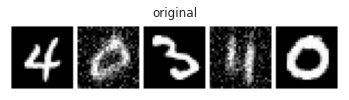

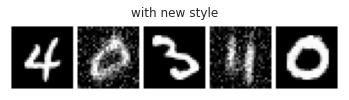

In [4]:
n_images = 5
z = torch.randn([n_images, G.z_dim], device=device)    # latent codes
if conditional:
    digits = torch.randint(0, G.c_dim, (n_images,), device=device)
    c = F.one_hot(digits, G.c_dim)          
else:
    c = None
misc.print_module_summary(G, [z, c])

ws = G.mapping(z, c, truncation_psi=1)
img = G.synthesis(ws, noise_mode='const', force_fp32=True)
img = postprocess_images(img)
plot_images(img, title='original')


img_ = generate_img_new_style(ws, block_layer_name='b4.conv1', index=3, direction=-1)
img_ = postprocess_images(img_)
plot_images(img_, title='with new style')

# Load classifier

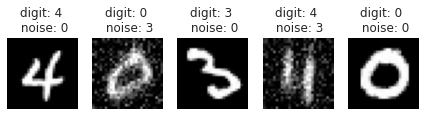

In [5]:
# predict digits
classifier_digits = CNN_MNIST(output_dim=10).to(device)
# classifier_digits.load_state_dict(torch.load(path_results / 'classifiers' / 'CNN_MNIST_weights_20220411_0826.pth', map_location=device)) # Confiance
# classifier_digits.load_state_dict(torch.load(path_results / 'classifiers' / 'CNN_MNIST_weights_20220210_1601.pth', map_location=device))
classifier_digits.load_state_dict(torch.load(path_results / 'classifiers' / 'CNN_mnist_stylegan2_blur_noise_maxSeverity3_proba50_20220510_1124.pth', map_location=device))
classifier_digits.eval()

# predict noise
classifier_noise = CNN_MNIST(output_dim=6).to(device)
# classifier_noise.load_state_dict(torch.load(path_results / 'classifiers' / 'CNN_noise_MNIST_weights_20220411_0841.pth', map_location=device)) # Confiance
classifier_noise.load_state_dict(torch.load(path_results / 'classifiers' / 'CNN_MNIST_noise_weights_20220210_1728.pth', map_location=device))
classifier_noise.eval()

imgs = G.synthesis(ws, noise_mode='const', force_fp32=True)
imgs = postprocess_images(imgs)
digit_pred = classifier_digits(imgs).argmax(dim=1).cpu()
noise_pred = classifier_noise(imgs).argmax(dim=1).cpu()

plt.figure(figsize=(15, 5))
for i in range(min(n_images, 5)):
    plt.subplot(1, 10, i+1)
    plt.imshow(imgs[i].cpu().squeeze(), cmap='gray')
    plt.title(f'digit: {digit_pred[i].numpy()} \n noise: {noise_pred[i].numpy()}')
    plt.axis('off')

# Gradient of score wrt W

In [6]:
CLASS_SELECTED = 0
n_images = 1000
batch_size = 32



if CLASS_SELECTED == 'all': 
    digits = torch.randint(0, G.c_dim, (n_images,), dtype=torch.int64)
else:
    digits = CLASS_SELECTED*torch.ones((n_images, ), dtype=torch.int64)

z_all = torch.zeros((n_images, G.z_dim))
w_all = torch.zeros((n_images, G.w_dim))
grads_all = torch.zeros((n_images, G.w_dim))
for idx_batch, labels in enumerate(DataLoader(digits, batch_size)):
    current_batch_size = labels.shape[0]
    
    z = torch.randn([current_batch_size, G.z_dim], device=device)    # latent codes
    c = F.one_hot(labels, G.c_dim).to(device)     

    # compute input
    w = G.mapping(z, c, truncation_psi=1, truncation_cutoff=8)[:, 0, :] # keep only the first element
    w.requires_grad = True

    # compute output
    imgs = G.synthesis(w.unsqueeze(1).repeat((1, G.num_ws, 1)), noise_mode='const', force_fp32=True)
    imgs = postprocess_images(imgs)

    digits_pred = classifier_digits(imgs)
    max_logit = digits_pred.max(axis=1).values
    max_softmax = F.softmax(digits_pred, dim=1).max(axis=1).values
    class_pred = F.softmax(digits_pred, dim=1).max(axis=1).indices

    # grad of output relative to input
    # function needs scalar output so we take the sum, and result will be the gradient for all samples relative to the sum of max logits,
    # which is the same as gradients of each sample relative to its output
    grad = torch.autograd.grad(max_logit.sum(), w)[0] 

    # save
    z_all[idx_batch*batch_size:(idx_batch+1)*batch_size] = z.cpu()
    w_all[idx_batch*batch_size:(idx_batch+1)*batch_size] = w.detach().cpu()
    grads_all[idx_batch*batch_size:(idx_batch+1)*batch_size] = grad.detach().cpu()

## one-class, use average gradient
only one transformation. e.g. 8 becomes 1

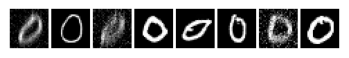

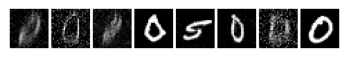

In [7]:
n_images_to_plot = 8
idx_imgs = np.random.randint(n_images, size=(n_images_to_plot))

w = w_all[idx_imgs].to(device)
grad = grads_all.mean(0).to(device)

imgs = G.synthesis(w.unsqueeze(1).repeat((1, G.num_ws, 1)), noise_mode='const', force_fp32=True)
imgs = postprocess_images(imgs)

digits_pred = classifier_digits(imgs)
max_logit = digits_pred.max(axis=1).values
max_softmax = F.softmax(digits_pred, dim=1).max(axis=1).values
class_pred = F.softmax(digits_pred, dim=1).max(axis=1).indices

plot_images(imgs)
# plt.title('before shifting: top class: {} : {:.0f}%'.format(class_pred.cpu().numpy(), 100*max_softmax.detach().cpu().numpy()))


# Move into opposite grad directions
w_new = w - 0.1*grad

imgs = G.synthesis(w_new.unsqueeze(1).repeat((1, G.num_ws, 1)), noise_mode='const', force_fp32=True)
imgs = postprocess_images(imgs)

digits_pred = classifier_digits(imgs)
max_logit = digits_pred.max(axis=1).values
max_softmax = F.softmax(digits_pred, dim=1).max(axis=1).values
class_pred = F.softmax(digits_pred, dim=1).max(axis=1).indices

plot_images(imgs)
# plt.title('after shifting: top class: {} : {:.0f}%'.format(class_pred.cpu().numpy(), 100*max_softmax.detach().cpu().numpy()))

## use sample-specific gradient
transform is different for each sample

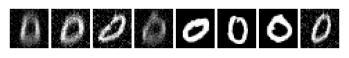

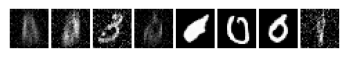

In [8]:
n_images_to_plot = 8
idx_imgs = np.random.randint(n_images, size=(n_images_to_plot))

w = w_all[idx_imgs].to(device)
grad = grads_all[idx_imgs].to(device)

imgs = G.synthesis(w.unsqueeze(1).repeat((1, G.num_ws, 1)), noise_mode='const', force_fp32=True)
imgs = postprocess_images(imgs)

digits_pred = classifier_digits(imgs)
max_logit = digits_pred.max(axis=1).values
max_softmax = F.softmax(digits_pred, dim=1).max(axis=1).values
class_pred = F.softmax(digits_pred, dim=1).max(axis=1).indices

plot_images(imgs)
# plt.title('before shifting: top class: {} : {:.0f}%'.format(class_pred.cpu().numpy(), 100*max_softmax.detach().cpu().numpy()))

# Move into opposite grad directions
w_new = w - 0.1*grad

imgs = G.synthesis(w_new.unsqueeze(1).repeat((1, G.num_ws, 1)), noise_mode='const', force_fp32=True)
imgs = postprocess_images(imgs)

digits_pred = classifier_digits(imgs)
max_logit = digits_pred.max(axis=1).values
max_softmax = F.softmax(digits_pred, dim=1).max(axis=1).values
class_pred = F.softmax(digits_pred, dim=1).max(axis=1).indices

plot_images(imgs)
# plt.title('after shifting: top class: {} : {:.0f}%'.format(class_pred.cpu().numpy(), 100*max_softmax.detach().cpu().numpy()))

# Corner cases

In [9]:
def compute_class_softmax_from_w(w, c):
    with torch.no_grad():
        w = w.to(device)
        imgs = G.synthesis(w.unsqueeze(1).repeat((1, G.num_ws, 1)), noise_mode='const', force_fp32=True)
        imgs = postprocess_images(imgs)

        digits_pred = classifier_digits(imgs)
        class_softmax = F.softmax(digits_pred, dim=1)[0, c]
    return class_softmax

In [10]:
%%time

w_corner_cases_all = torch.zeros((n_images, G.w_dim))
for idx in range(n_images):
    w = w_all[idx].detach().clone().unsqueeze(0)
    c = digits[idx]
    direction = grads_all[idx]

    # finds quickly but roughly when prediction shifts
    class_softmax = compute_class_softmax_from_w(w, c)
    if class_softmax > 0.5: # only work with initially well classified samples
        strength = 0.01
        while class_softmax > 0.5:
            w -= strength*direction
            class_softmax = compute_class_softmax_from_w(w, c)

        # refine
        strength = 0.001
        while class_softmax < 0.5 - 0.001:
            w += strength*direction
            class_softmax = compute_class_softmax_from_w(w, c)

        w_corner_cases_all[idx] = w

CPU times: user 2min 8s, sys: 60.2 ms, total: 2min 8s
Wall time: 2min 8s


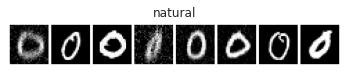

tensor([1.0000, 1.0000, 1.0000, 0.9802, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


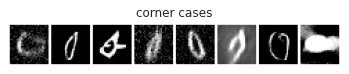

tensor([0.5058, 0.5313, 0.5085, 0.5992, 0.5821, 0.7329, 0.5479, 0.5078],
       device='cuda:0', grad_fn=<MaxBackward0>)


In [63]:
n_images_to_plot = 8
idx_imgs = np.random.randint(len(w_all), size=(n_images_to_plot))

w = w_all[idx_imgs].to(device)

imgs = G.synthesis(w.unsqueeze(1).repeat((1, G.num_ws, 1)), noise_mode='const', force_fp32=True)
imgs = postprocess_images(imgs)

digits_pred = classifier_digits(imgs)
max_logit = digits_pred.max(axis=1).values
max_softmax = F.softmax(digits_pred, dim=1).max(axis=1).values
class_pred = F.softmax(digits_pred, dim=1).max(axis=1).indices

plot_images(imgs)
plt.title('natural')
plt.show()
print(max_softmax)

w = w_corner_cases_all[idx_imgs].to(device)

imgs = G.synthesis(w.unsqueeze(1).repeat((1, G.num_ws, 1)), noise_mode='const', force_fp32=True)
imgs = postprocess_images(imgs)

digits_pred = classifier_digits(imgs)
max_logit = digits_pred.max(axis=1).values
max_softmax = F.softmax(digits_pred, dim=1).max(axis=1).values
class_pred = F.softmax(digits_pred, dim=1).max(axis=1).indices

plot_images(imgs)
plt.title('corner cases')
plt.show()
print(max_softmax)


In [41]:
with open(path_model, 'rb') as f:
    D = pickle.load(f)['D'].to(device)

In [46]:
n_images = 8
idx_imgs = np.random.randint(len(w_all), size=(n_images))

w = w_all[idx_imgs].to(device)
c = F.one_hot(digits[idx_imgs], G.c_dim).to(device)     

imgs = G.synthesis(w.unsqueeze(1).repeat((1, G.num_ws, 1)), noise_mode='const', force_fp32=True)
D(imgs, c)

tensor([[ 0.8837],
        [-0.4498],
        [ 0.9900],
        [-0.4675],
        [-0.0088],
        [-0.3793],
        [ 1.4027],
        [ 0.2475]], device='cuda:0')

In [11]:
w_avg = w_all.mean(0, keepdim=True)
dist_natural_to_center = torch.cdist(w_all, w_avg).numpy()
dist_corner_cases_to_center = torch.cdist(w_corner_cases_all, w_avg).numpy()
dist_corner_cases_to_natural = (w_corner_cases_all-w_all).square().sum(1).sqrt().numpy()

In [70]:
plt.figure()
(w_corner_cases_all-w_all).abs().mean(0)

tensor([0.1368, 0.0522, 0.0960, 0.0909, 0.1066, 0.0599, 0.0505, 0.0854, 0.0681,
        0.1231, 0.0940, 0.0544, 0.0974, 0.0568, 0.0662, 0.0594, 0.0587, 0.0724,
        0.0950, 0.0474, 0.0620, 0.0704, 0.0742, 0.1671, 0.0639, 0.1049, 0.0789,
        0.0630, 0.1044, 0.0954, 0.0980, 0.0401, 0.0392, 0.0969, 0.0533, 0.1183,
        0.1389, 0.0599, 0.0979, 0.0423, 0.0582, 0.0703, 0.0733, 0.0753, 0.0881,
        0.0487, 0.1345, 0.0914, 0.0493, 0.0580, 0.1060, 0.0736, 0.0881, 0.0467,
        0.0705, 0.0485, 0.0431, 0.0432, 0.0653, 0.1359, 0.0746, 0.0917, 0.0809,
        0.1380, 0.0411, 0.1151, 0.0456, 0.1021, 0.0618, 0.0803, 0.0691, 0.0761,
        0.0546, 0.0678, 0.0686, 0.0552, 0.0383, 0.0713, 0.0501, 0.0683, 0.0541,
        0.0896, 0.0802, 0.0561, 0.0609, 0.1666, 0.0658, 0.0918, 0.0683, 0.0743,
        0.0559, 0.0516, 0.0592, 0.0946, 0.1095, 0.0717, 0.0757, 0.0707, 0.0734,
        0.1169, 0.0683, 0.0639, 0.0848, 0.0424, 0.0713, 0.0889, 0.0743, 0.0784,
        0.0852, 0.1187, 0.0601, 0.0843, 

<Figure size 432x288 with 0 Axes>

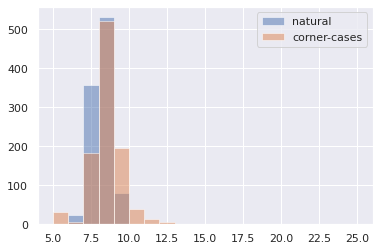

In [30]:
plt.figure()
plt.hist(dist_natural_to_center, alpha=0.5, bins=range(int(dist_natural_to_center.min()), int(dist_natural_to_center.max()+1)), label='natural')
plt.hist(dist_corner_cases_to_center, alpha=0.5, bins=range(int(dist_corner_cases_to_center.min()), int(dist_corner_cases_to_center.max()+1)), label='corner-cases');
plt.legend()

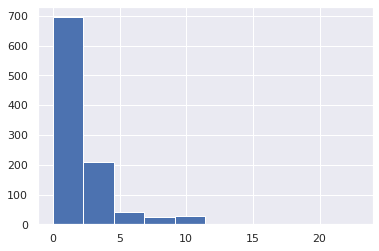

In [13]:
plt.figure()
plt.hist(dist_corner_cases_to_natural);

In [14]:
np.mean(dist_corner_cases_to_natural)

2.220165

In [15]:
np.mean(dist_corner_cases_to_center)

8.612443

In [16]:
np.mean(dist_natural_to_center)

8.180999

# t-SNE

In [17]:
is_corner_case = torch.cat((torch.zeros(w_all.shape[0]), torch.ones(w_corner_cases_all.shape[0]))).bool()
torch.logical_not(is_corner_case)

tensor([ True,  True,  True,  ..., False, False, False])

(-25.0, 25.0)

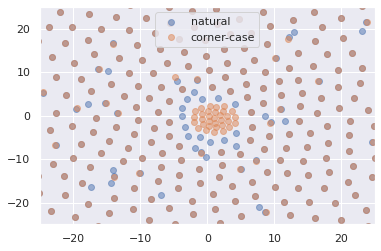

In [58]:
# w = torch.cat((w_all, w_corner_cases_all))
# is_corner_case = torch.cat((torch.zeros(w_all.shape[0]), torch.ones(w_corner_cases_all.shape[0]))).bool()
# w_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(w.cpu().numpy())

plt.figure()
plt.scatter(w_embedded[torch.logical_not(is_corner_case), 0], w_embedded[torch.logical_not(is_corner_case), 1], c='C0', label='natural', alpha=0.5)
plt.xlim((-25, 25))
plt.ylim((-25, 25))

# plt.figure()
plt.scatter(w_embedded[is_corner_case, 0], w_embedded[is_corner_case, 1], c='C1', label='corner-case', alpha=0.5)
plt.legend()
plt.xlim((-25, 25))
plt.ylim((-25, 25))

In [19]:
w_embedded.shape

(2000, 2)

In [20]:
class LatentToClass(Dataset):

    def __init__(self, latent_codes, labels):
        assert latent_codes.shape[0] == labels.shape[0], "not same number of elements"
        self.latent_codes = latent_codes
        self.labels = labels

    def __len__(self):
        return len(self.latent_codes)
    
    def __getitem__(self, idx):
        return self.latent_codes[idx], self.labels[idx]


class TinyModel(pl.LightningModule):

    def __init__(self, input_dim=512, output_dim=10):
        super().__init__()

        self.linear1 = torch.nn.Linear(input_dim, 512)
        self.linear2 = torch.nn.Linear(512, 512)
        self.linear3 = torch.nn.Linear(512, output_dim)

    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = (y_hat.argmax(dim=1) == y).sum() / y.shape[0]
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        val_loss = F.cross_entropy(y_hat, y)
        acc = (y_hat.argmax(dim=1) == y).sum() / y.shape[0]
        self.log("val_loss", val_loss)
        self.log("val_acc", acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.unsqueeze(0), y.unsqueeze(0)
        y_hat = self(x)
        acc = (y_hat.argmax(dim=1) == y).sum() / y.shape[0]
        self.log("test_acc", acc)
        return acc


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

In [21]:
 
latent_w = torch.cat((w_all, w_corner_cases_all))
labels = torch.cat((torch.zeros(w_all.shape[0], dtype=int), torch.ones(w_corner_cases_all.shape[0], dtype=int)))
dataset_w = LatentToClass(latent_w, labels)
dataset_size = len(dataset_w)


In [22]:
train_set, val_set, test_set = torch.utils.data.random_split(dataset_w, [int(0.8*dataset_size), int(0.1*dataset_size), int(0.1*dataset_size)])

train_loader = DataLoader(train_set, batch_size=512, num_workers=4)
val_loader = DataLoader(val_set, batch_size=512, num_workers=4)
trainer = pl.Trainer(max_epochs=10, accelerator="gpu", devices=1)
model = TinyModel()

trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
trainer.test(dataloaders=test_set)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /d/alecoz/projects/stylegan2/code/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 262 K 
1 | linear2 | Linear | 262 K 
2 | linear3 | Linear | 5.1 K 
-----------------------------------
530 K     Trainable params
0         Non-trainable params
530 K     Total params
2.122     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/d/alecoz/miniconda3/envs/torch/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1933: PossibleUserWarning: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/d/alecoz/miniconda3/envs/torch/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1446: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  rank_zero_warn(
Restoring states from the checkpoint path at /d/alecoz/projects/stylegan2/code/lightning_logs/version_0/checkpoints/epoch=9-step=40.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /d/alecoz/projects/stylegan2/code/lightning_logs/version_0/checkpoints/epoch=9-step=40.ckpt


Testing: 0it [00:00, ?it/s]

/d/alecoz/miniconda3/envs/torch/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:72: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 512. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6150000095367432     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.6150000095367432}]